In [4]:
import copy
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss

import matplotlib.pyplot as plt
import yfinance as yf

# Basic Functions

In [5]:
# 실제 Y와 예측치 시각화
def plot_prediction(Y_true_pred):
    plt.figure(figsize=(16, 8))
    plt.plot(Y_true_pred, linewidth=5, label=Y_true_pred.columns)
    plt.xticks(fontsize=25, rotation=0)
    plt.yticks(fontsize=25)
    plt.xlabel('Index', fontname='serif', fontsize=28)
    plt.legend(fontsize=20)
    plt.grid()
    plt.show()

In [6]:
def error_analysis(X_Data, Y_Pred, Residual, graph_on=False):
    if graph_on == True:
        ##### 시각화
        # 잔차의 정규본포성 확인
        # sns.displot(Residual, norm_hist='True', fit=stats.norm)
        sns.displot(Residual, kind='hist')
        plt.show()

        # 잔차의 등분산성 확인
        temp = pd.concat([Y_Pred, Residual.reset_index().iloc[:,[1]]], axis=1)
        sns.scatterplot(x='Pred', y='Error', data=temp)
        plt.show()

        # 잔차의 자기상관성 확인
        sm.graphics.tsa.plot_acf(Residual, lags=50, use_vlines=True)
        plt.show()

    ##### 통계량
    # 정규분포
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Residual)],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # 등분산성
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Residual, X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'],
                                      columns=['Test Statistics', 'p-value', 'Alternative']).T

    # 자기상관
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,50]).iloc[:,0]),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,50]).iloc[:,1])], axis=1).T
    Autocorrelation.index = ['Test Statistics', 'p-value']
    Autocorrelation.columns = ['Autocorr(lag10)', 'Autocorr(lag50)']

    Error_Analysis = pd.concat([Normality, Heteroscedasticity, Autocorrelation], join='outer', axis=1)

    return Error_Analysis

In [7]:
# 검증 함수화
def evaluation_reg(Y_real, Y_pred):
    MAE = mean_absolute_error(Y_real, Y_pred)
    MSE = mean_squared_error(Y_real, Y_pred)
    MAPE = mean_absolute_percentage_error(Y_real, Y_pred)
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T

    return Score

In [8]:
# Train & Test 모두의 검증 함수화
def evaluation_reg_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te):
    Score_tr = evaluation_reg(Y_real_tr, Y_pred_tr)
    Score_te = evaluation_reg(Y_real_te, Y_pred_te)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']

    return Score_trte

# Data preprocessing

In [9]:
def get_prices(code, name):
    ticker = yf.Ticker(code)
    data = ticker.history(period="max")[["Close"]]
    data.rename(columns={"Close":name}, inplace=True)
    data.index = pd.to_datetime(data.index).strftime('%Y-%m-%d')
    return data

In [10]:
data = pd.DataFrame()

In [11]:
# code and names
# Code and names
apple = ["AAPL", "Apple"]
tesla = ["TSLA", "Tesla"]
bond = ["^FVX", "bond_rate"]
dow = ["^DJI", "Dow"]
tech_index = ["XLK", "tech_index"]
health_index = ["XLV", "health_index"]
consumer_dis_index = ["XLY", "consumer_dis_index"]
consumer_staples_index = ["XLP", "consumer_staples_index"]
energy_index = ["XLE", "energy_index"]
financial_index = ["XLF", 'financial_index']
industrial_index = ["XLI", "industrial_index"]
material_index = ["XLB", "material_index"]
real_estate_index = ["XLRE", "real_estate_index"]
utilities_index = ["XLU", "utilities_index"]
jpyusd = ["JPYUSD=X", "JPYUSD"]
cnyusd = ["CNYUSD=X", "CNYUSD"]
eurusd = ["EURUSD=X", "EURUSD"]

data_lists = [apple, tesla, bond, dow, tech_index, health_index, consumer_dis_index, consumer_staples_index,
              energy_index, financial_index, industrial_index, material_index, real_estate_index,
              utilities_index, jpyusd, cnyusd, eurusd]

In [12]:
df = pd.DataFrame()

for list in data_lists:
    code = list[0]
    name = list[1]
    data = get_prices(code, name)
    df[name] = data
    
df

,Apple,Tesla,bond_rate,Dow,tech_index,health_index,consumer_dis_index,consumer_staples_index,energy_index,financial_index,industrial_index,material_index,real_estate_index,utilities_index,JPYUSD,CNYUSD,EURUSD
Date,,,,,,,,,,,,,,,,,
1980-12-12,0.099450,NaN,13.630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15,0.094261,NaN,13.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-16,0.087343,NaN,14.040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-17,0.089504,NaN,13.870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-18,0.092099,NaN,13.790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,175.740005,276.040009,4.419,34907.109375,171.842941,132.695724,174.469681,72.160965,92.676109,34.854198,105.181526,82.233582,36.637894,64.695755,0.006787,0.137574,1.073422
2023-09-15,175.009995,274.390015,4.453,34618.238281,168.539993,131.650009,171.484985,71.565002,91.335999,34.675003,104.573997,81.318001,36.499001,64.418007,0.006780,0.137440,1.063717
2023-09-18,177.970001,265.279999,4.462,34624.300781,169.350006,131.449997,169.619995,71.540001,92.110001,34.770000,104.690002,80.980003,36.180000,64.370003,0.006763,0.137478,1.066826


In [13]:
df.index = pd.to_datetime(df.index)
df

,Apple,Tesla,bond_rate,Dow,tech_index,health_index,consumer_dis_index,consumer_staples_index,energy_index,financial_index,industrial_index,material_index,real_estate_index,utilities_index,JPYUSD,CNYUSD,EURUSD
Date,,,,,,,,,,,,,,,,,
1980-12-12,0.099450,NaN,13.630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15,0.094261,NaN,13.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-16,0.087343,NaN,14.040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-17,0.089504,NaN,13.870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-18,0.092099,NaN,13.790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,175.740005,276.040009,4.419,34907.109375,171.842941,132.695724,174.469681,72.160965,92.676109,34.854198,105.181526,82.233582,36.637894,64.695755,0.006787,0.137574,1.073422
2023-09-15,175.009995,274.390015,4.453,34618.238281,168.539993,131.650009,171.484985,71.565002,91.335999,34.675003,104.573997,81.318001,36.499001,64.418007,0.006780,0.137440,1.063717
2023-09-18,177.970001,265.279999,4.462,34624.300781,169.350006,131.449997,169.619995,71.540001,92.110001,34.770000,104.690002,80.980003,36.180000,64.370003,0.006763,0.137478,1.066826


In [14]:
data = df.copy()

data['date'] = pd.to_datetime(data.index)
data = data.reset_index().drop(["Date"], axis=1)
data

,Apple,Tesla,bond_rate,Dow,tech_index,health_index,consumer_dis_index,consumer_staples_index,energy_index,financial_index,industrial_index,material_index,real_estate_index,utilities_index,JPYUSD,CNYUSD,EURUSD,date
0,0.099450,NaN,13.630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1980-12-12
1,0.094261,NaN,13.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1980-12-15
2,0.087343,NaN,14.040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1980-12-16
3,0.089504,NaN,13.870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1980-12-17
4,0.092099,NaN,13.790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1980-12-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10778,175.740005,276.040009,4.419,34907.109375,171.842941,132.695724,174.469681,72.160965,92.676109,34.854198,105.181526,82.233582,36.637894,64.695755,0.006787,0.137574,1.073422,2023-09-14
10779,175.009995,274.390015,4.453,34618.238281,168.539993,131.650009,171.484985,71.565002,91.335999,34.675003,104.573997,81.318001,36.499001,64.418007,0.006780,0.137440,1.063717,2023-09-15
10780,177.970001,265.279999,4.462,34624.300781,169.350006,131.449997,169.619995,71.540001,92.110001,34.770000,104.690002,80.980003,36.180000,64.370003,0.006763,0.137478,1.066826,2023-09-18
10781,179.070007,266.500000,4.521,34517.730469,169.259995,131.559998,168.770004,71.370003,91.250000,34.730000,104.250000,80.910004,35.990002,64.019997,0.006775,0.137163,1.069267,2023-09-19


In [15]:
# add time index
# data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
# data["time_idx"] -= data["time_idx"].min()
# data["time_idx"] = data.index
data["country"] = "US"

In [16]:
# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")
data["log_apple"] = np.log(data.Apple)
data["log_tesla"] = np.log(data.Tesla)

In [17]:
data.dropna(inplace=True)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1995 entries, 8782 to 10782
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Apple                   1995 non-null   float64       
 1   Tesla                   1995 non-null   float64       
 2   bond_rate               1995 non-null   float64       
 3   Dow                     1995 non-null   float64       
 4   tech_index              1995 non-null   float64       
 5   health_index            1995 non-null   float64       
 6   consumer_dis_index      1995 non-null   float64       
 7   consumer_staples_index  1995 non-null   float64       
 8   energy_index            1995 non-null   float64       
 9   financial_index         1995 non-null   float64       
 10  industrial_index        1995 non-null   float64       
 11  material_index          1995 non-null   float64       
 12  real_estate_index       1995 non-null   float64  

In [19]:
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)
data['time_idx'] = data.index
data

,Apple,Tesla,bond_rate,Dow,tech_index,health_index,consumer_dis_index,consumer_staples_index,energy_index,financial_index,...,utilities_index,JPYUSD,CNYUSD,EURUSD,date,country,month,log_apple,log_tesla,time_idx
0,24.848478,15.114667,1.398,17050.750000,37.280872,59.642277,70.730675,39.916466,49.383331,16.221682,...,33.919159,0.008339,0.157577,1.124000,2015-10-08,US,10,3.212797,2.715666,0
1,25.443027,14.712667,1.406,17084.490234,37.443344,59.913647,70.812660,40.005424,49.063110,16.117653,...,33.757267,0.008338,0.157642,1.128694,2015-10-09,US,10,3.236442,2.688709,1
2,25.325027,14.372000,1.400,17131.859375,37.488480,60.071239,71.149796,40.110584,48.429707,16.131527,...,34.057907,0.008321,0.157846,1.136997,2015-10-12,US,10,3.231793,2.665282,2
3,25.368141,14.616667,1.362,17081.890625,37.407246,59.318390,70.767113,39.867935,47.924400,16.006693,...,33.980816,0.008333,0.158403,1.135551,2015-10-13,US,10,3.233494,2.682162,3
4,25.009596,14.458667,1.280,16924.750000,37.335041,59.204559,70.047333,39.406887,48.337189,15.874920,...,33.973110,0.008353,0.157920,1.138498,2015-10-14,US,10,3.219260,2.671294,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,175.740005,276.040009,4.419,34907.109375,171.842941,132.695724,174.469681,72.160965,92.676109,34.854198,...,64.695755,0.006787,0.137574,1.073422,2023-09-14,US,9,5.169006,5.620546,1990
1991,175.009995,274.390015,4.453,34618.238281,168.539993,131.650009,171.484985,71.565002,91.335999,34.675003,...,64.418007,0.006780,0.137440,1.063717,2023-09-15,US,9,5.164843,5.614551,1991
1992,177.970001,265.279999,4.462,34624.300781,169.350006,131.449997,169.619995,71.540001,92.110001,34.770000,...,64.370003,0.006763,0.137478,1.066826,2023-09-18,US,9,5.181615,5.580786,1992
1993,179.070007,266.500000,4.521,34517.730469,169.259995,131.559998,168.770004,71.370003,91.250000,34.730000,...,64.019997,0.006775,0.137163,1.069267,2023-09-19,US,9,5.187777,5.585374,1993


# Create dataset and dataloader

In [20]:
var = []

for list in data_lists:
    var.append(list[1])

var

['Apple',
 'Tesla',
 'bond_rate',
 'Dow',
 'tech_index',
 'health_index',
 'consumer_dis_index',
 'consumer_staples_index',
 'energy_index',
 'financial_index',
 'industrial_index',
 'material_index',
 'real_estate_index',
 'utilities_index',
 'JPYUSD',
 'CNYUSD',
 'EURUSD']

In [21]:
max_prediction_length = 5
max_encoder_length = 60

training_cut_off = data['time_idx'].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cut_off],
    time_idx = "time_idx",
    target = "Apple",
    group_ids = ["country"],
    min_encoder_length = max_encoder_length // 2,
    max_encoder_length = max_encoder_length,
    min_prediction_length = 1,
    max_prediction_length = max_prediction_length,
    static_categoricals = [],
    static_reals = [],
    time_varying_known_categoricals = [],
    time_varying_known_reals = ["date", "month"],
    time_varying_unknown_reals = [
        'bond_rate',
        'Dow',
        'tech_index',
        'health_index',
        'consumer_dis_index',
        'consumer_staples_index',
        'energy_index',
        'financial_index',
        'industrial_index',
        'material_index',
        'real_estate_index',
        'utilities_index',
        'JPYUSD',
        'CNYUSD',
        'EURUSD',
        'log_apple',
    ],
    # add_relative_time_idx = True,
    add_target_scales = True,
    add_encoder_length = True,
)

In [22]:
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

In [23]:
# create dataloaders for model
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# Create baseline model

In [36]:
import os
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("stock price prediction")


mlflow.pytorch.autolog()

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# calculate baseline mean absolute error, i.e., predict the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
baseline_predictions

2023/09/21 12:04:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '29ef170f72de48bfb72eb1ab88d5119b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow
2023/09/21 12:04:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '969b2f3d1cc54087ada8120c62cd8dbd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow
2023/09/21 12:04:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c34ee3fd0b0c4d8fbfb2249c2f79ba07', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow
2023/09/21 12:04:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '044fcea0260a40d8877f8b2390a4998d', which will track hyperparameters, performance metrics, model artifacts, and lineage i

Prediction(output=tensor([[174.2100, 174.2100, 174.2100, 174.2100, 174.2100]], device='mps:0'), x=None, index=None, decoder_lengths=None, y=(tensor([[175.7400, 175.0100, 177.9700, 179.0700, 175.4900]], device='mps:0'), None))

In [37]:
MAE()(baseline_predictions.output, baseline_predictions.y)

tensor(2.4460, device='mps:0')

In [38]:
import matplotlib.pyplot as plt

baseline_pred_data = baseline_predictions.output.cpu().numpy()[0]
baseline_real_data = baseline_predictions.y[0].cpu().numpy()[0]

baseline_df = pd.DataFrame()
baseline_df["pred"] = baseline_pred_data
baseline_df["real"] = baseline_real_data
baseline_df

,pred,real
0,174.210007,175.740005
1,174.210007,175.009995
2,174.210007,177.970001
3,174.210007,179.070007
4,174.210007,175.490005


<Axes: >

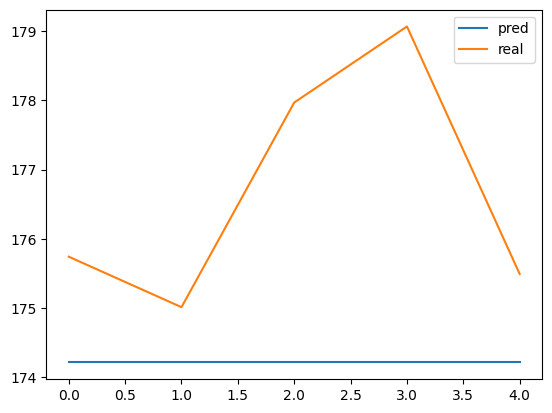

In [39]:
baseline_df.plot()

# Train the Temporal Fusion Transformer

In [40]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator = 'cpu',
    gradient_clip_val = 0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 0.03,
    hidden_size = 16,
    attention_head_size = 1,
    dropout = 0.1,
    hidden_continuous_size = 8,
    loss = QuantileLoss(),
    optimizer = "Ranger"
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 30.1k


2023/09/21 12:05:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '929256065adb4ba793908cc9f3f6a9a8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow





































































































`Trainer.fit` stopped: `max_steps=100` reached.
Finding best initial lr: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]
Learning rate set to 0.07943282347242808
Restoring states from the checkpoint path at /Users/woojin/Documents/github/projects/stock/.lr_find_8e3fa060-563b-4aa2-8f6b-fe1f36950366.ckpt
Restored all states from the checkpoint at /Users/woojin/Documents/github/projects/stock/.lr_find_8e3fa060-563b-4aa2-8f6b-fe1f36950366.ckpt
Finding best initial lr:   6%|▌         | 6/100 [03:35<56:16, 35.92s/it]


suggested learning rate : 0.07943282347242808


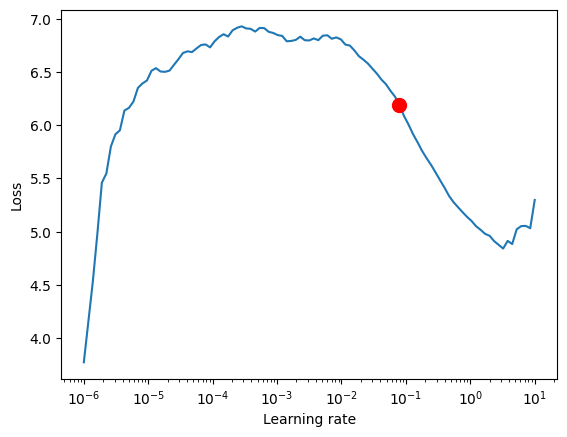

In [41]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
    max_lr = 10.0,
    min_lr = 1e-6,
)

print(f"suggested learning rate : {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# Train model

In [42]:
# configure network and trainer

early_stop_callback = EarlyStopping(monitor = "val_loss", min_delta = 1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs = 30,
    accelerator = 'cpu',
    enable_model_summary = True,
    gradient_clip_val = 0.23,
    limit_train_batches = 50,
    callbacks = [lr_logger, early_stop_callback],
    logger = logger
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 0.03,
    hidden_size = 19,
    attention_head_size = 2,
    dropout = 0.22,
    hidden_continuous_size = 12,
    loss = QuantileLoss(),
    log_interval = 10,
    optimizer = "Ranger",
    reduce_on_plateau_patience = 4
)

print(f"Number of parameters in network : {tft.size()/1e3:.1f}k")

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network : 46.3k


In [43]:
# fit network
trainer.fit(
    tft,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader
)

2023/09/21 12:05:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '27c24e9580f74e13b5569f0334d35fbb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow
Missing logger folder: lightning_logs/lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 504   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.9 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 22.0 K
6  | decoder_va

Epoch 29: 100%|██████████| 31/31 [00:10<00:00,  3.04it/s, v_num=0, train_loss_step=0.877, val_loss=1.110, train_loss_epoch=0.965]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 31/31 [00:10<00:00,  2.92it/s, v_num=0, train_loss_step=0.877, val_loss=1.110, train_loss_epoch=0.965]


# Hyperprameter tuning

In [44]:
# # Check that MPS is available
# if not torch.backends.mps.is_available():
#     if not torch.backends.mps.is_built():
#         print("MPS not available because the current PyTorch install was not "
#               "built with MPS enabled.")
#     else:
#         print("MPS not available because the current MacOS version is not 12.3+ "
#               "and/or you do not have an MPS-enabled device on this machine.")

# else:
#     mps_device = torch.device("mps")

#     # Create a Tensor directly on the mps device
#     x = torch.ones(5, device=mps_device)
#     # Or
#     x = torch.ones(5, device="mps")

#     # Any operation happens on the GPU
#     y = x * 2

#     # Move your model to mps just like any other device
#     model = YourFavoriteNet()
#     model.to(mps_device)

#     # Now every call runs on the GPU
#     pred = model(x)

In [45]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [46]:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [47]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path = "optuna_test",
    n_trials = 10,
    max_epochs = 50,
    gradient_clip_val_range = (0.01, 1.0),
    hidden_size_range = (8, 128),
    hidden_continuous_size_range = (8, 128),
    attention_head_size_range = (1, 4),
    learning_rate_range = (0.001, 0.1),
    dropout_range = (0.1, 0.3),
    trainer_kwargs = dict(limit_train_batches = 30),
    reduce_on_plateau_patience = 4,
    use_learning_rate_finder = False
)

# from google.colab import drive
# drive.mount('./content/drive')
# import os
# os.chdir('/content/drive/MyDrive/Colab Notebook')

# with open("tft_tesla.plk", "wb") as fout:
#     pickle.dump(study. fout)

print(study.best_trial.params)

[I 2023-09-21 12:11:38,688] A new study created in memory with name: no-name-0bc25c62-3b45-4175-9c8f-0f3f207bac9f
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/09/21 12:11:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8788135d24084287b4299bcd8e0ba9cf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow
[W 2023-09-21 12:11:39,112] Trial 0 failed with parameters: {'gradient_clip_val': 0.06330455600009514, 'hidden_size': 9, 'dropout': 0.2182811914154805, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.09113306340496463} because of the following error: NotImplementedError("The operator 'aten::upsample_linear1d.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this featu

NotImplementedError: The operator 'aten::upsample_linear1d.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

# Evaluate performance

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calculate mean absolute error on validation set
# predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
predictions = tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

tensor(7.4125)

In [ ]:
# raw predictions are dictionary from which all kind including quantiles can be extracted
# raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
raw_predictions = tft.predict(val_dataloader, return_x=True)

NotImplementedError: The operator 'aten::upsample_linear1d.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [ ]:
# for idx in range(10):
# best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)
tft.plot_prediction(raw_predictions.y, raw_predictions.output,idx=0, add_loss_to_title=True)

TypeError: 'NoneType' object is not subscriptable

# Worst performers